In [1]:
# import the modules and models here
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from skimage import restoration
import os
from tensorflow.keras.models import load_model
import pandas as pd
from pathlib import Path

2025-12-11 07:18:33.459274: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-11 07:18:33.459402: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-11 07:18:33.462358: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-11 07:18:33.481710: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [33]:
TEST_DIR = "blurred_cv2/"
ENHANCED_DIR = "blurry2_enhanced/"

MODEL_PATHS = {
    'mobilenet': 'mobilenet2.h5',
    #'inception': 'InceptionV3.h5',
}

MODEL_CLASSES = [
    'Ambulance', 'Barge', 'Bicycle', 'Boat', 'Bus', 'Car', 
    'Cart', 'Caterpillar', 'Helicopter', 'Limousine', 
    'Motorcycle', 'Segway', 'Snowmobile', 'Tank', 'Taxi', 
    'Truck', 'Van'
]

YOUR_CLASSES = ['bicycle', 'boat', 'bus', 'car', 'helicopter', 'motorcycle', 'truck']

CLASS_MAPPING = {
    'bicycle': 'Bicycle',
    'boat': 'Boat',
    'bus': 'Bus',
    'car': 'Car',
    'helicopter': 'Helicopter',
    'motorcycle': 'Motorcycle',
    'truck': 'Truck',
}

In [3]:
def unsharp_masking(image, kernel_size=(5, 5), sigma=1.0, alpha=1.5):
    """
    Apply unsharp masking to enhance edges in a blurry image.
    
    Args:
        image: Input image (grayscale or BGR)
        kernel_size: Size of Gaussian kernel (width, height)
        sigma: Standard deviation for Gaussian blur
        alpha: Sharpening strength factor (typically 1.0-2.0)
        
    Returns:
        Sharpened image
    """
    # Convert to float for processing
    img_float = image.astype(np.float32)
    
    # Apply Gaussian blur to get blurred version
    blurred = cv2.GaussianBlur(img_float, kernel_size, sigma)
    
    # Create mask: original - blurred (high-frequency components)
    mask = img_float - blurred
    
    # Add scaled mask back to original: original + α(mask)
    sharpened = img_float + alpha * mask
    
    # Clip values to valid range and convert back
    sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)
    
    return sharpened

def blind_deconvolution(image, psf_size=15, n_iterations=30, regularization=0.001):
    """
    Apply blind deconvolution to estimate and reverse blur.
    
    Args:
        image: Input blurry image (grayscale or BGR)
        psf_size: Size of the point spread function (PSF) to estimate
        n_iterations: Number of iterations for convergence
        regularization: Regularization weight to prevent overfitting
        
    Returns:
        Deblurred image
    """
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        is_color = True
    else:
        gray = image.copy()
        is_color = False
    
    # Normalize to [0, 1]
    img_normalized = gray.astype(np.float64) / 255.0
    
    # Initialize PSF as a small Gaussian kernel
    psf_init = np.ones((psf_size, psf_size)) / (psf_size ** 2)
    
    # Apply Richardson-Lucy deconvolution
    try:
        # richardson_lucy returns ONLY the deconvolved image, not the PSF
        deconvolved = restoration.richardson_lucy(
            img_normalized,
            psf_init,
            num_iter=n_iterations,
            clip=False
        )
        result = deconvolved
        
    except Exception as e:
        print(f"Deconvolution failed: {e}. Using Wiener filter.")
        deconvolved_wiener = restoration.unsupervised_wiener(
            img_normalized,
            psf_init
        )[0]
        result = deconvolved_wiener
    
    # Convert back to uint8 [0, 255]
    result = np.clip(result * 255, 0, 255).astype(np.uint8)
    
    # If original was color, apply to all channels
    if is_color:
        deblurred_color = np.zeros_like(image)
        for i in range(3):
            channel = image[:, :, i].astype(np.float64) / 255.0
            # FIX: richardson_lucy returns only one value, not two
            channel_deblurred = restoration.richardson_lucy(
                channel,
                psf_init,
                num_iter=n_iterations,
                clip=False
            )
            deblurred_color[:, :, i] = np.clip(channel_deblurred * 255, 0, 255)
        
        return deblurred_color.astype(np.uint8)
    
    return result

In [11]:
def enhance_image(img_rgb, method):
    """
    Apply unsharp masking enhancement to image.
    Choose unsharp masking as it's faster for batch processing.
    """
    # Ensure RGB (remove alpha if present)
    if img_rgb.shape[2] == 4:
        img_rgb = img_rgb[:, :, :3]
    
    # Convert RGB to BGR for OpenCV
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

    if method == "unsharp":
        # Apply unsharp masking
        denoised = cv2.fastNlMeansDenoisingColored(img_bgr, None, h=10)
        enhanced = unsharp_masking(denoised, alpha=1.5)
        enhanced_rgb = cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB)
        return enhanced_rgb
    else:
        # Apply blind deconvolution
        enhanced = blind_deconvolution(img_bgr, n_iterations=10)
        enhanced_rgb = cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB)
        return enhanced_rgb

In [12]:
def compare_methods(image, save_path=None):
    """
    Compare original, unsharp masking, and blind deconvolution results.
    
    Args:
        image: Input blurry image
        save_path: Optional path to save comparison figure
    """
    # Apply both methods
    unsharp_result = BlurryImageProcessor.unsharp_masking(image, alpha=1.5)
    blind_result = BlurryImageProcessor.blind_deconvolution(image, n_iterations=10)
    
    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Handle color conversion for display
    if len(image.shape) == 3:
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        unsharp_rgb = cv2.cvtColor(unsharp_result, cv2.COLOR_BGR2RGB)
        blind_rgb = cv2.cvtColor(blind_result, cv2.COLOR_BGR2RGB)
    else:
        img_rgb = image
        unsharp_rgb = unsharp_result
        blind_rgb = blind_result
    
    axes[0].imshow(img_rgb, cmap='gray' if len(image.shape) == 2 else None)
    axes[0].set_title('Original Blurry Image')
    axes[0].axis('off')
    
    axes[1].imshow(unsharp_rgb, cmap='gray' if len(image.shape) == 2 else None)
    axes[1].set_title('Unsharp Masking')
    axes[1].axis('off')
    
    axes[2].imshow(blind_rgb, cmap='gray' if len(image.shape) == 2 else None)
    axes[2].set_title('Blind Deconvolution')
    axes[2].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    plt.show()
    
    return unsharp_result, blind_result

In [14]:
# ============================================================================
# SAVE ENHANCED DATASET
# ============================================================================

def save_enhanced_dataset(input_dir, output_dir, classes, max_dim=1200):
    """Apply enhancement and save to disk"""
    print(f"\n{'='*70}")
    print("CREATING ENHANCED DATASET")
    print("="*70)
    
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    for class_name in classes:
        input_class_dir = os.path.join(input_dir, class_name)
        output_class_dir = os.path.join(output_dir, class_name)
        
        if not os.path.exists(input_class_dir):
            continue
        
        Path(output_class_dir).mkdir(parents=True, exist_ok=True)
        
        images = [f for f in os.listdir(input_class_dir) 
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        if not images:
            continue
        
        print(f"\n  {class_name}/ ({len(images)} images)")
        
        for i, img_file in enumerate(images):
            if i > 0 and i % 20 == 0:
                print(f"    {i}/{len(images)}...")
            
            input_path = os.path.join(input_class_dir, img_file)
            img = cv2.imread(input_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            ### NEW: Resize if too large
            h, w = img_rgb.shape[:2]
            largest = max(h, w)
            
            if largest > max_dim:
                scale = max_dim / largest
                new_w = int(w * scale)
                new_h = int(h * scale)
                img_rgb = cv2.resize(img_rgb, (new_w, new_h),
                                     interpolation=cv2.INTER_AREA)
                # (optional) tell the user we resized
                # print(f"      Resized {img_file} from {w}x{h} to {new_w}x{new_h}")

            # Apply enhancement
            if "blind" in output_dir:
                cur_method = "blind"
            else:
                cur_method = "unsharp"
            enhanced = enhance_image(img_rgb, cur_method)
            
            # Save
            enhanced_bgr = cv2.cvtColor(enhanced, cv2.COLOR_RGB2BGR)
            output_path = os.path.join(output_class_dir, img_file)
            cv2.imwrite(output_path, enhanced_bgr)
    
    print(f"\n✅ Enhanced dataset created: {output_dir}/")

In [7]:
# ============================================================================
# LOAD MODELS & RUN PREDICTIONS
# ============================================================================

def load_models():
    models = []
    model_names = []
    
    print("\n" + "="*70)
    print("LOADING MODELS")
    print("="*70)
    
    for name, path in MODEL_PATHS.items():
        if os.path.exists(path):
            try:
                print(f"\nLoading {name}...")
                model = load_model(path)
                models.append(model)
                model_names.append(name)
                print(f"  ✅ {name}")
            except Exception as e:
                print(f"  ❌ Error")
    
    print(f"\n✅ Loaded {len(models)} models")
    return models

def ensemble_predictions(models, img):
    predictions = [model.predict(img, verbose=0) for model in models]
    predictions = np.array(predictions)
    summed = np.sum(predictions, axis=0)
    class_index = np.argmax(summed, axis=1)[0]
    confidence = summed[0][class_index] / len(models)
    return class_index, confidence

def run_predictions(models, data_dir, exp_name):
    print(f"\n{'='*70}")
    print(f"{exp_name}")
    print("="*70)
    
    all_results = []
    correct = 0
    total = 0
    
    for class_name in YOUR_CLASSES:
        class_path = os.path.join(data_dir, class_name)
        
        if not os.path.exists(class_path):
            continue
        
        images = [f for f in os.listdir(class_path)]
        
        if not images:
            continue
        
        print(f"\n  {class_name}/ ({len(images)} images)")
        
        class_correct = 0
        
        for i, img_file in enumerate(images):
            if i > 0 and i % 20 == 0:
                print(f"    {i}/{len(images)}...")
            
            img_path = os.path.join(class_path, img_file)
            
            try:
                img = cv2.imread(img_path)
    
                if img is None:
                    print(f"    ⚠️ Could not load: {img_file}")
                    continue
                
                # Convert BGR to RGB and ensure 3 channels
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                # Remove alpha channel if present
                if len(img_rgb.shape) == 3 and img_rgb.shape[2] == 4:
                    img_rgb = img_rgb[:, :, :3]
                
                # Resize
                img_resized = cv2.resize(img_rgb, (224, 224))
                img_batch = img_resized[np.newaxis, ...].astype(np.float32)
                
                pred_idx, confidence = ensemble_predictions(models, img_batch)
                predicted_model_class = MODEL_CLASSES[pred_idx]
                
                predicted_your_class = None
                for your_cls, model_cls in CLASS_MAPPING.items():
                    if model_cls == predicted_model_class:
                        predicted_your_class = your_cls
                        break
                
                if predicted_your_class is None:
                    predicted_your_class = 'unknown'
                
                is_correct = (predicted_your_class.lower() == class_name.lower())
                if is_correct:
                    class_correct += 1
                    correct += 1
                
                total += 1
                all_results.append({
                    'true_class': class_name,
                    'filename': img_file,
                    'predicted_class': predicted_your_class,
                    'confidence': confidence,
                    'correct': is_correct
                })
                
            except Exception as e:
                print(e)
                continue
        
        class_acc = (class_correct / len(images)) * 100 if images else 0
        print(f"    ✓ {class_correct}/{len(images)} = {class_acc:.1f}%")
    
    df = pd.DataFrame(all_results)
    overall_acc = (correct / total) * 100 if total > 0 else 0
    
    print(f"\nOverall: {correct}/{total} = {overall_acc:.2f}%")
    
    return df, overall_acc

In [8]:
# Create enhanced dataset
#save_enhanced_dataset(TEST_DIR, ENHANCED_DIR, YOUR_CLASSES)

# Load models
models = load_models()


LOADING MODELS

Loading mobilenet...


2025-12-11 07:23:53.103712: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10534 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1


  ✅ mobilenet

✅ Loaded 1 models


In [36]:
TEST_DIR = "vehicle_dataset2/test"

In [35]:
# Experiment 1: Baseline
results_exp1, acc_exp1 = run_predictions(
    models, TEST_DIR, "EXPERIMENT 1: BASELINE"
)
results_exp1.to_csv('experiment1_baseline.csv', index=False)
print(results_exp1)


EXPERIMENT 1: BASELINE

  bicycle/ (32 images)
    20/32...
    ✓ 19/32 = 59.4%

  boat/ (41 images)
    20/41...
    40/41...
    ✓ 38/41 = 92.7%

  bus/ (44 images)
    20/44...
    40/44...
    ✓ 24/44 = 54.5%

  car/ (45 images)
    20/45...
    40/45...
    ✓ 43/45 = 95.6%

  helicopter/ (45 images)
    20/45...
    40/45...
    ✓ 41/45 = 91.1%

  motorcycle/ (17 images)
    ✓ 8/17 = 47.1%

  truck/ (45 images)
    20/45...
    40/45...
    ✓ 41/45 = 91.1%

Overall: 214/269 = 79.55%
    true_class                                           filename  \
0      bicycle  20220818_13_35_24_475_000_3Du7psGgitewpjIJfxWY...   
1      bicycle  20220820_15_01_22_636_000_VTCWoTXihygMJko2o6jw...   
2      bicycle  20220816_18_20_21_622_000_nHYqnNks2LWvHJXVPB6O...   
3      bicycle  20220821_16_35_01_959_000_Cmsqzc7LqxQcQY8E1p19...   
4      bicycle  20220817_10_36_21_052_000_UjADWWWKTUNfUBUzbSCC...   
..         ...                                                ...   
264      truck         

In [37]:
save_enhanced_dataset(TEST_DIR, ENHANCED_DIR, YOUR_CLASSES)


CREATING ENHANCED DATASET

  bicycle/ (32 images)
    20/32...

  boat/ (41 images)
    20/41...
    40/41...

  bus/ (44 images)
    20/44...
    40/44...

  car/ (45 images)
    20/45...
    40/45...

  helicopter/ (45 images)
    20/45...
    40/45...

  motorcycle/ (17 images)

  truck/ (45 images)
    20/45...
    40/45...

✅ Enhanced dataset created: blurry2_enhanced//


In [38]:
# Experiment 2: Enhanced
results_exp2, acc_exp2 = run_predictions(
    models, ENHANCED_DIR, "EXPERIMENT 2: MSR ENHANCED"
)
results_exp2.to_csv('experiment2_enhanced.csv', index=False)

# Comparison
print(f"\n\n{'='*70}")
print("COMPARISON")
print("="*70)

improvement = acc_exp2 - acc_exp1

print(f"\n  Baseline:   {acc_exp1:6.2f}%")
print(f"  Enhanced:   {acc_exp2:6.2f}%")
print(f"  {'─'*30}")
print(f"  Change:     {improvement:+6.2f}%")

if improvement > 5:
    print(f"\n  ✅ SIGNIFICANT IMPROVEMENT!")
elif improvement > 2:
    print(f"\n  ✓ Good improvement")
elif improvement < -2:
    print(f"\n  ❌ Try different algorithm")
else:
    print(f"\n  ➖ Minimal change")

print(f"\n📈 Per-Class:")
print("-"*70)

for class_name in YOUR_CLASSES:
    exp1_class = results_exp1[results_exp1['true_class'] == class_name]
    exp2_class = results_exp2[results_exp2['true_class'] == class_name]
    
    if len(exp1_class) > 0 and len(exp2_class) > 0:
        exp1_acc = (exp1_class['correct'].sum() / len(exp1_class)) * 100
        exp2_acc = (exp2_class['correct'].sum() / len(exp2_class)) * 100
        change = exp2_acc - exp1_acc
        
        indicator = "✅" if change > 5 else ("❌" if change < -5 else "  ")
        
        print(f"  {class_name:12s}: {exp1_acc:5.1f}% → {exp2_acc:5.1f}% ({indicator} {change:+5.1f}%)")

print(f"\n{'='*70}")
print("✅ COMPLETE!")


EXPERIMENT 2: MSR ENHANCED

  bicycle/ (32 images)
    20/32...
    ✓ 15/32 = 46.9%

  boat/ (41 images)
    20/41...
    40/41...
    ✓ 37/41 = 90.2%

  bus/ (44 images)
    20/44...
    40/44...
    ✓ 20/44 = 45.5%

  car/ (45 images)
    20/45...
    40/45...
    ✓ 40/45 = 88.9%

  helicopter/ (45 images)
    20/45...
    40/45...
    ✓ 38/45 = 84.4%

  motorcycle/ (17 images)
    ✓ 6/17 = 35.3%

  truck/ (45 images)
    20/45...
    40/45...
    ✓ 41/45 = 91.1%

Overall: 197/269 = 73.23%


COMPARISON

  Baseline:    79.55%
  Enhanced:    73.23%
  ──────────────────────────────
  Change:      -6.32%

  ❌ Try different algorithm

📈 Per-Class:
----------------------------------------------------------------------
  bicycle     :  59.4% →  46.9% (❌ -12.5%)
  boat        :  92.7% →  90.2% (    -2.4%)
  bus         :  54.5% →  45.5% (❌  -9.1%)
  car         :  95.6% →  88.9% (❌  -6.7%)
  helicopter  :  91.1% →  84.4% (❌  -6.7%)
  motorcycle  :  47.1% →  35.3% (❌ -11.8%)
  truck       : 

In [39]:
save_enhanced_dataset(TEST_DIR, "blind_enhanced", YOUR_CLASSES)


CREATING ENHANCED DATASET

  bicycle/ (32 images)
    20/32...

  boat/ (41 images)
    20/41...
    40/41...

  bus/ (44 images)
    20/44...
    40/44...

  car/ (45 images)
    20/45...
    40/45...

  helicopter/ (45 images)
    20/45...
    40/45...

  motorcycle/ (17 images)

  truck/ (45 images)
    20/45...
    40/45...

✅ Enhanced dataset created: blind_enhanced/


In [40]:
# Experiment 3: Enhanced (blind deconv)
results_exp3, acc_exp3 = run_predictions(
    models, "blind_enhanced", "EXPERIMENT 3: BLIND DECONVOLUTION ENHANCED"
)
results_exp3.to_csv('experiment3_enhanced.csv', index=False)

# Comparison
print(f"\n\n{'='*70}")
print("COMPARISON")
print("="*70)

improvement = acc_exp3 - acc_exp1

print(f"\n  Baseline:   {acc_exp1:6.2f}%")
print(f"  Enhanced:   {acc_exp3:6.2f}%")
print(f"  {'─'*30}")
print(f"  Change:     {improvement:+6.2f}%")

if improvement > 5:
    print(f"\n  ✅ SIGNIFICANT IMPROVEMENT!")
elif improvement > 2:
    print(f"\n  ✓ Good improvement")
elif improvement < -2:
    print(f"\n  ❌ Try different algorithm")
else:
    print(f"\n  ➖ Minimal change")

print(f"\n📈 Per-Class:")
print("-"*70)

for class_name in YOUR_CLASSES:
    exp1_class = results_exp1[results_exp1['true_class'] == class_name]
    exp3_class = results_exp3[results_exp3['true_class'] == class_name]
    
    if len(exp1_class) > 0 and len(exp3_class) > 0:
        exp1_acc = (exp1_class['correct'].sum() / len(exp1_class)) * 100
        exp3_acc = (exp3_class['correct'].sum() / len(exp3_class)) * 100
        change = exp3_acc - exp1_acc
        
        indicator = "✅" if change > 5 else ("❌" if change < -5 else "  ")
        
        print(f"  {class_name:12s}: {exp1_acc:5.1f}% → {exp3_acc:5.1f}% ({indicator} {change:+5.1f}%)")

print(f"\n{'='*70}")
print("✅ COMPLETE!")


EXPERIMENT 3: BLIND DECONVOLUTION ENHANCED

  bicycle/ (32 images)
    20/32...
    ✓ 26/32 = 81.2%

  boat/ (41 images)
    20/41...
    40/41...
    ✓ 36/41 = 87.8%

  bus/ (44 images)
    20/44...
    40/44...
    ✓ 25/44 = 56.8%

  car/ (45 images)
    20/45...
    40/45...
    ✓ 39/45 = 86.7%

  helicopter/ (45 images)
    20/45...
    40/45...
    ✓ 31/45 = 68.9%

  motorcycle/ (17 images)
    ✓ 1/17 = 5.9%

  truck/ (45 images)
    20/45...
    40/45...
    ✓ 35/45 = 77.8%

Overall: 193/269 = 71.75%


COMPARISON

  Baseline:    79.55%
  Enhanced:    71.75%
  ──────────────────────────────
  Change:      -7.81%

  ❌ Try different algorithm

📈 Per-Class:
----------------------------------------------------------------------
  bicycle     :  59.4% →  81.2% (✅ +21.9%)
  boat        :  92.7% →  87.8% (    -4.9%)
  bus         :  54.5% →  56.8% (    +2.3%)
  car         :  95.6% →  86.7% (❌  -8.9%)
  helicopter  :  91.1% →  68.9% (❌ -22.2%)
  motorcycle  :  47.1% →   5.9% (❌ -41.2%)


In [32]:
rm -rf "./blind_enhanced"

In [25]:
def test_simple(image_path):
    """Simpler version for Jupyter notebooks."""
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    print("Processing...")
    unsharp = unsharp_masking(img, alpha=2.5)
    blind = blind_deconvolution(img, n_iterations=10)
    
    unsharp_rgb = cv2.cvtColor(unsharp, cv2.COLOR_BGR2RGB)
    blind_rgb = cv2.cvtColor(blind, cv2.COLOR_BGR2RGB)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(img_rgb)
    axes[0].set_title('Original', fontsize=14)
    axes[0].axis('off')
    
    axes[1].imshow(unsharp_rgb)
    axes[1].set_title('Unsharp Masking', fontsize=14)
    axes[1].axis('off')
    
    axes[2].imshow(blind_rgb)
    axes[2].set_title('Blind Deconvolution', fontsize=14)
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Done!")

Processing...


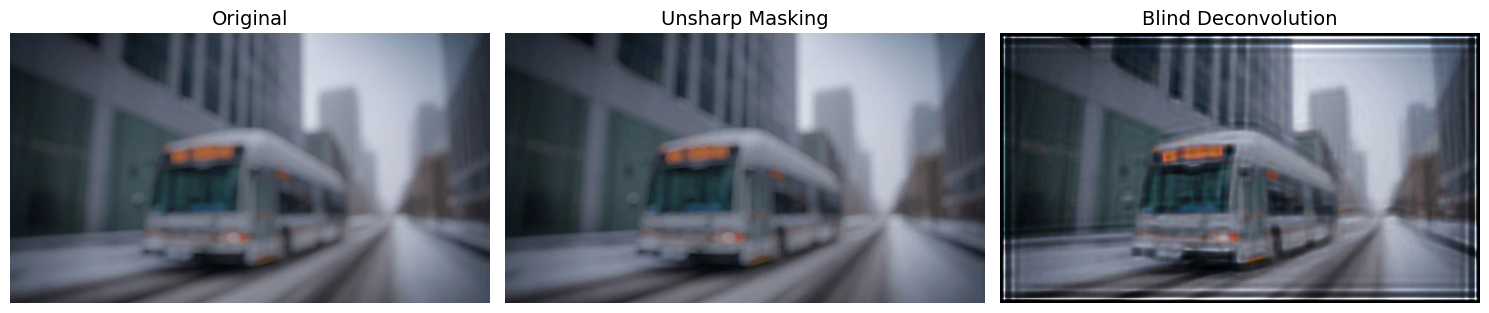

✅ Done!


In [26]:
# alpha 1.5, iter 30
test_simple("./blurry/bus/bus71.png")

Processing...


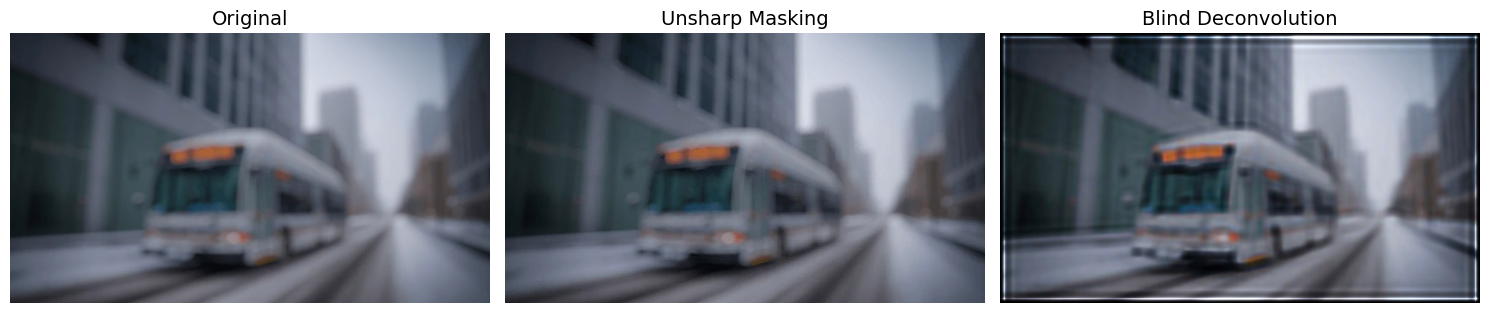

✅ Done!


In [47]:
# alpha 1.5, iter 10
test_simple("./blurry/bus/bus71.png")

Processing...


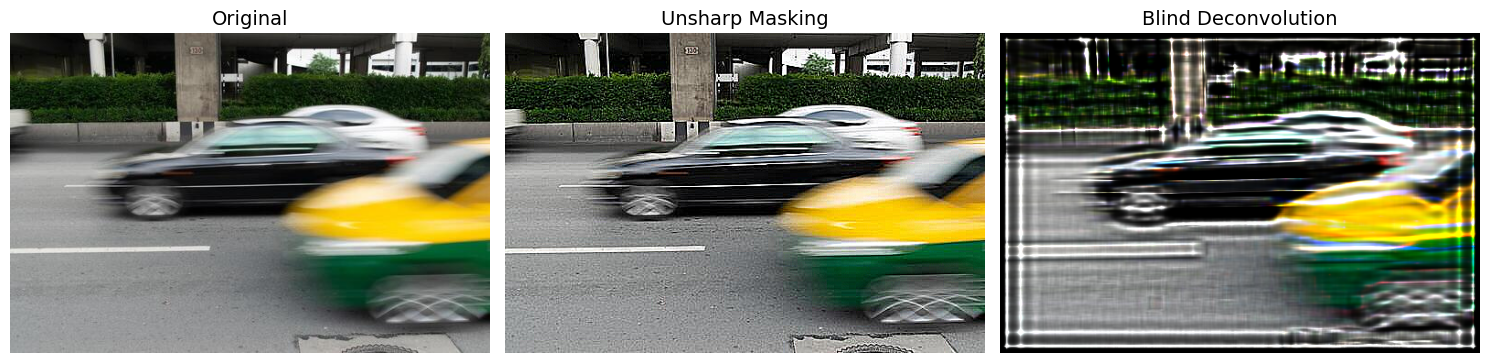

✅ Done!


In [53]:
# alpha 3.5, iter 40
test_simple("./blurry/car/car37.jpg")

Processing...


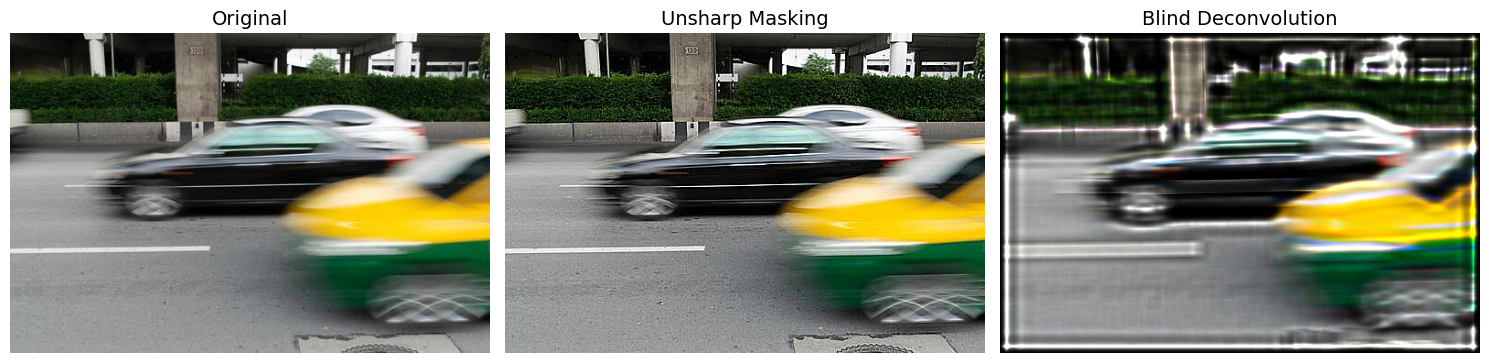

✅ Done!


In [46]:
# alpha 1.5, iter 10
test_simple("./blurry/car/car37.jpg")

Processing...


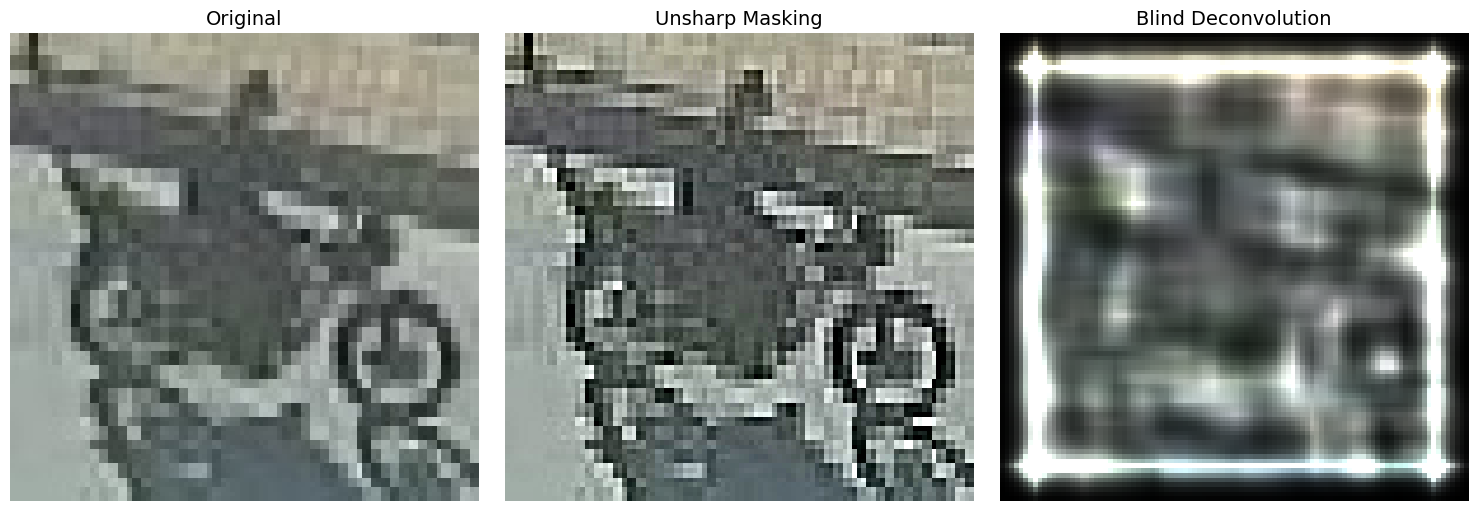

✅ Done!


In [44]:
test_simple("./blurry/bicycle/bike67.jpg") #FTF

Processing...


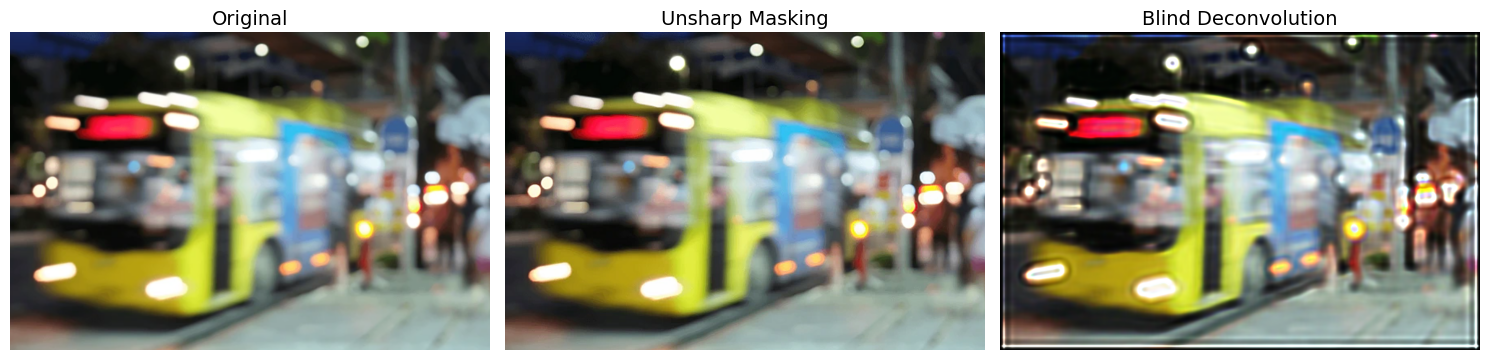

✅ Done!


In [48]:
test_simple("./blurry/bus/bus69.png") # FTT

In [17]:
baseline_test, acc_exp_test = run_predictions(
    models, 'vehicle_dataset/test', "EXPERIMENT 4: BASELINE (on test set only)"
)


EXPERIMENT 4: BASELINE (on test set only)

  bicycle/ (32 images)
    20/32...
    ✓ 19/32 = 59.4%

  boat/ (40 images)
    20/40...
    ✓ 38/40 = 95.0%

  bus/ (44 images)
    20/44...
    40/44...
    ✓ 17/44 = 38.6%

  car/ (45 images)
    20/45...
    40/45...
    ✓ 43/45 = 95.6%

  helicopter/ (45 images)
    20/45...
    40/45...
    ✓ 23/45 = 51.1%

  motorcycle/ (17 images)
    ✓ 1/17 = 5.9%

  truck/ (45 images)
    20/45...
    40/45...
    ✓ 36/45 = 80.0%

Overall: 177/268 = 66.04%


Processing...


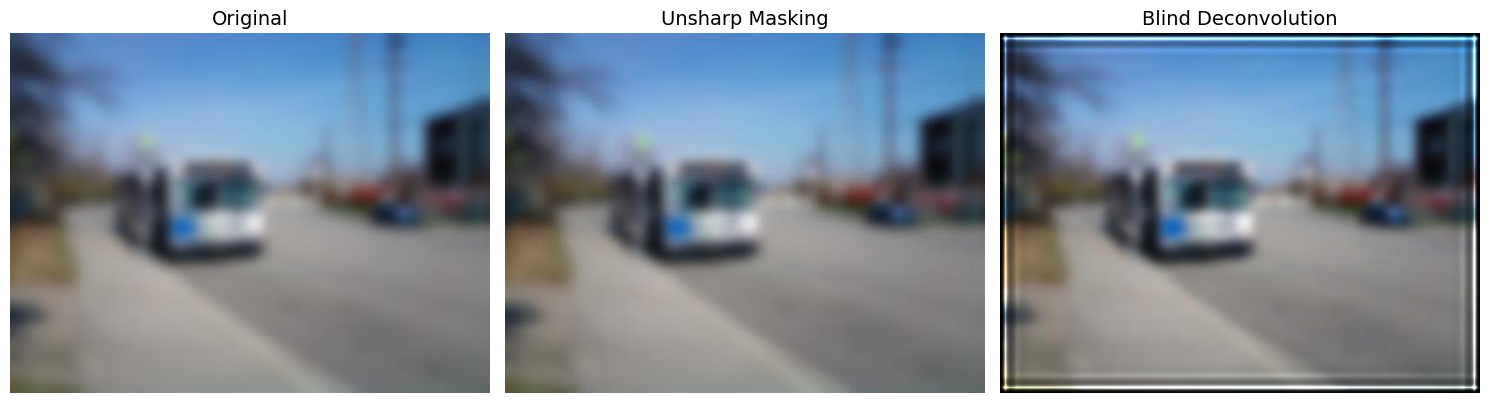

✅ Done!


In [26]:
test_simple("./blurred_images_pillow/bus/2_124.jpg")

In [ ]:
test_simple("./normal_img/bus/2_11.jpg")